# LeNet

## Historical Context and Relevance of LeNet-5

The **LeNet-5** architecture, developed by **Yann LeCun** and collaborators between 1988
and 1998, represents one of the foundational early architectures in the field of
convolutional neural networks. Its design was aimed at efficiently solving the problem
of automatic handwritten character recognition. This architecture was successfully
implemented in real-world systems for automatic check processing in the United States,
making it one of the first industrial applications of deep learning.

LeNet-5 demonstrates that it is possible to learn hierarchical representations directly
from images while preserving the spatial structure of the data and significantly
reducing the number of parameters compared to traditional fully connected networks.
Unlike the previously used fully connected multilayer perceptrons, which treat each
pixel as an independent feature and lose spatial layout information, LeNet-5 explicitly
exploits the two-dimensional structure of images and the local correlation between
nearby pixels.

This architecture illustrates how the combination of convolutions, subsampling, and
nonlinear activation functions allows the construction of systems robust to variations
in position, scale, or moderate deformations of handwritten patterns, while maintaining
manageable computational complexity. In this way, LeNet-5 serves as a direct predecessor
of many modern computer vision architectures, establishing design principles that
persist to this day.

## Conceptual Foundations of LeNet-5

Before the introduction of LeNet-5, image recognition was mainly approached using fully
connected multilayer perceptrons. This approach has a fundamental structural limitation:
the image is flattened into a one-dimensional vector, and the model completely loses
information about the relative spatial arrangement of pixels. As a result, the system
becomes extremely sensitive to small translations, local deformations, or changes in the
object's position within the image. Additionally, the number of parameters grows rapidly
with image size, making training difficult and favoring overfitting, especially with
limited datasets.

LeNet-5 introduced a decisive conceptual change through the combined use of
convolutions, subsampling, and weight sharing. Convolutional layers detect local
patterns, such as edges, corners, or strokes, while preserving the image's
two-dimensional structure. Each convolutional filter slides over the image and acts as a
specialized detector for a certain type of visual pattern. Subsampling, implemented
using _average pooling_ operations, progressively reduces the spatial resolution of
feature maps. This reduction provides approximate invariance to small translations and
deformations while reducing computational cost and the number of parameters in
subsequent layers.

Weight sharing is another key design element: the same convolutional filter is applied
across all positions in the image. Instead of learning a separate set of weights for
each input pixel, a reduced set of filters is learned and reused throughout the image.
This mechanism drastically reduces the number of parameters and enhances generalization,
since the same pattern (e.g., a vertical stroke) may appear in different regions of the
image and should be recognized consistently in all of them.

Together, these mechanisms allow LeNet-5 to learn hierarchical representations
progressively. Early layers capture simple, local patterns, while deeper layers combine
these patterns to form higher-level features, increasingly abstract and task-specific.
This hierarchical feature organization remains a fundamental principle in most modern
convolutional neural network architectures, from AlexNet to transformer-based vision
models.

## Original LeNet-5 Architecture

The original LeNet-5 architecture consists of seven trainable layers combining
convolutions, subsampling, and fully connected layers. The input consists of grayscale
images of size $32 \times 32$, slightly larger than the standard MNIST image size of
$28 \times 28$. This enlargement introduces a margin around the digit, facilitating the
application of convolutional filters and handling small translations without losing
relevant edge information.

Simplified, the architecture is organized into a convolutional part followed by a fully
connected part. The convolutional part alternates convolutional layers and _average
pooling_ layers, while the final part consists of dense layers that perform
classification. The characteristic dimensions of each layer can be summarized as
follows:

| Layer  | Type            | Input                    | Output                   |
| ------ | --------------- | ------------------------ | ------------------------ |
| C1     | Convolution     | $32 \times 32 \times 1$  | $28 \times 28 \times 6$  |
| S2     | Average Pooling | $28 \times 28 \times 6$  | $14 \times 14 \times 6$  |
| C3     | Convolution     | $14 \times 14 \times 6$  | $10 \times 10 \times 16$ |
| S4     | Average Pooling | $10 \times 10 \times 16$ | $5 \times 5 \times 16$   |
| C5     | Convolution     | $5 \times 5 \times 16$   | $1 \times 1 \times 120$  |
| F6     | Fully Connected | 120                      | 84                       |
| Output | Fully Connected | 84                       | 10                       |

The original architecture uses sigmoid or $\tanh$ activation functions and applies
_average pooling_ instead of the now more common _max pooling_. The total number of
trainable parameters is around 60,000, relatively small compared to fully connected
networks of similar size. Despite its apparent simplicity, LeNet-5 establishes a
structural pattern still present in many contemporary architectures: a convolutional
part for extracting spatial features followed by one or more dense layers that perform
final classification using linear combinations of the extracted features.

## PyTorch Implementation

This section presents a modern, functional implementation inspired by LeNet using
PyTorch. The goal is to have a complete workflow, executable end-to-end and directly
convertible into a Jupyter Notebook. The MNIST dataset is used as the reference dataset
for handwritten digit classification.

### Importing Libraries

First, the necessary libraries from Python’s standard library and third-party packages
are imported, including modules for model construction, data handling, visualization,
and embedding analysis.

In [1]:
# Standard libraries
from typing import Any

# Third-party libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.manifold import TSNE

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA available: True


### Device Setup

The device is automatically selected based on GPU availability. If CUDA is available,
the GPU is used; otherwise, the model runs on the CPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

Device used: cuda


### Auxiliary Visualization Function

A helper function is defined to visually inspect examples from the dataset, displaying a
set of images with their corresponding labels. This helps quickly verify that
preprocessing is correct and samples are interpreted properly.

In [3]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    if len(images) == 1:
        axes = [axes]

    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap="gray")
        ax.set_title(f"Digit: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Loading and Preprocessing the MNIST Dataset

The MNIST dataset contains grayscale images of handwritten digits sized $28 \times 28$.
Preprocessing includes normalization using the mean $\mu = 0.1307$ and standard
deviation $\sigma = 0.3081$, estimated from the dataset itself. Normalization is defined
as:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}.
$$

This centers the data and scales it, facilitating and stabilizing the training of deep
networks by improving the numerical conditioning of optimization operations.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


### Creating DataLoaders

DataLoaders are created from the training and test sets to batch samples, shuffle
training examples, and efficiently handle data transfer to the computation device.

In [5]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

### Visual Inspection of the Dataset

Before training, it is useful to inspect some training samples. The mean and standard
deviation of a batch are also computed to verify proper normalization.

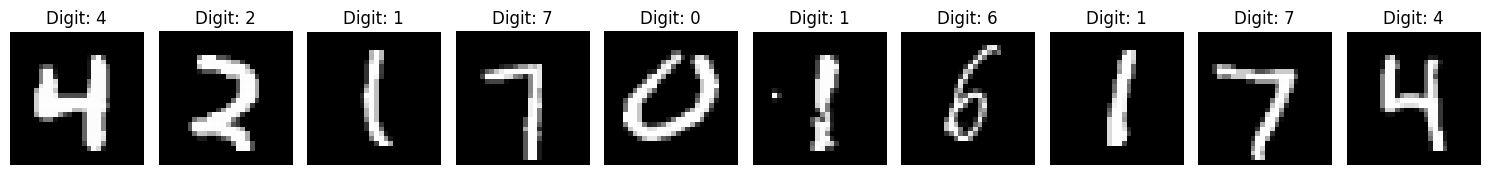

Batch mean: -0.036
Batch standard deviation: 0.962


In [6]:
images, labels = next(iter(train_dataloader))
show_images(images[:10], labels[:10])

print(f"Batch mean: {images.mean():.3f}")
print(f"Batch standard deviation: {images.std():.3f}")

## Defining a Modern LeNet Version in PyTorch

A modern, simplified version of LeNet is defined, adapted to MNIST and current deep
learning practices. While not exactly replicating the original LeNet-5, it preserves the
design spirit: a convolutional part for spatial feature extraction and a fully connected
part for classification. Batch normalization and ReLU activation are included, standard
in contemporary architectures, improving convergence speed and training stability.

In [7]:
class LeNet(nn.Module):
    def __init__(self, input_channels: int = 1):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=4, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

The `features` block applies two convolutional layers with spatial resolution reduction
via `stride=2`, followed by batch normalization and ReLU activation.
`nn.AdaptiveAvgPool2d((1, 1))` then adaptively reduces each feature map to size
$1 \times 1$ per channel, making the architecture robust to small spatial input
variations. The `classifier` block flattens the features and applies a linear layer to
produce logits for the 10 digit classes, later interpreted by `CrossEntropyLoss`, which
internally applies softmax.

### Model Instantiation and Analysis

The model is instantiated, moved to the selected device, and `torchinfo.summary`
provides a structured architecture overview, including input/output dimensions and
parameter counts.

In [8]:
model = LeNet().to(device)

summary(
    model,
    input_size=(BATCH_SIZE, 1, 28, 28),
    device=str(device)
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 8,922


## Training Setup

Training hyperparameters, optimizer, and loss function are defined. AdamW is used,
combining Adam’s advantages with explicit weight decay regularization. The chosen loss
is `CrossEntropyLoss`, suitable for multi-class classification with integer labels.

In [9]:
NUM_EPOCHS = 2
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

loss_function = nn.CrossEntropyLoss()

## Training and Validation Loop

Training is organized in epochs. Each epoch updates model parameters on the training
set, then evaluates performance on the test set without updating parameters. Loss and
accuracy are recorded for both sets to analyze learning progression and detect issues
such as overfitting.

In [10]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(NUM_EPOCHS):

    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [TRAIN]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [TEST]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_losses.append(test_loss / len(test_dataloader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}")
    print(f"  Train → Loss: {train_losses[-1]:.4f} | Acc: {train_accuracies[-1]:.2f}%")
    print(f"  Test  → Loss: {test_losses[-1]:.4f} | Acc: {test_accuracies[-1]:.2f}%")

Epoch 1/2 [TEST]: 100%|██████████| 313/313 [00:00<00:00, 573.51it/s]


Epoch 1
  Train → Loss: 0.9047 | Acc: 79.04%
  Test  → Loss: 0.3631 | Acc: 92.53%


Epoch 2/2 [TEST]: 100%|██████████| 313/313 [00:00<00:00, 598.59it/s]

Epoch 2
  Train → Loss: 0.2954 | Acc: 93.04%
  Test  → Loss: 0.2082 | Acc: 94.83%


`model.train()` activates training-specific behaviors, such as updating batch
normalization statistics and applying dropout if present. `model.eval()` disables these
behaviors for deterministic evaluation, and `torch.no_grad()` during validation avoids
gradient computation, reducing memory usage and computation time.

## Visualizing Metric Evolution

After training, loss and accuracy evolution for training and testing is plotted. This
visual analysis helps identify overfitting, underfitting, or learning stagnation,
guiding potential architecture or hyperparameter adjustments.

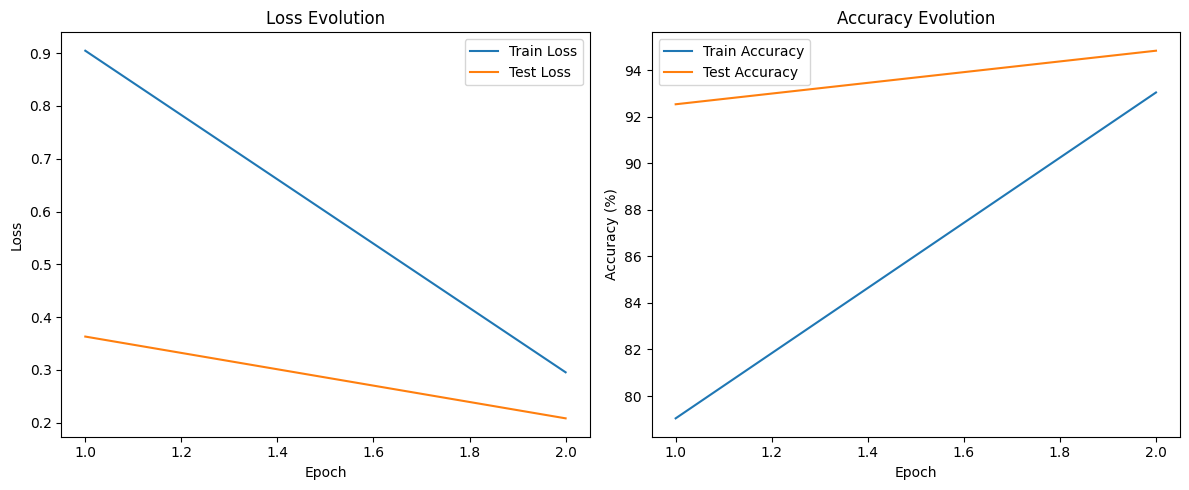

In [11]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Evolution")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Evolution")

plt.tight_layout()
plt.show()

Comparing training and testing curves provides insights into model generalization. For
example, increasing training accuracy with stagnant or decreasing test accuracy usually
indicates overfitting, while high loss on both sets suggests insufficient model capacity
or training time.

## Visualizing Embeddings with t-SNE

Finally, the structure of embeddings produced by the model is analyzed using t-SNE
(_t-distributed Stochastic Neighbor Embedding_). The model’s linear outputs (logits) are
extracted as example representations. t-SNE projects these high-dimensional vectors into
2D space while preserving local neighborhood relations. This projection visually shows
how the model separates different classes in feature space.

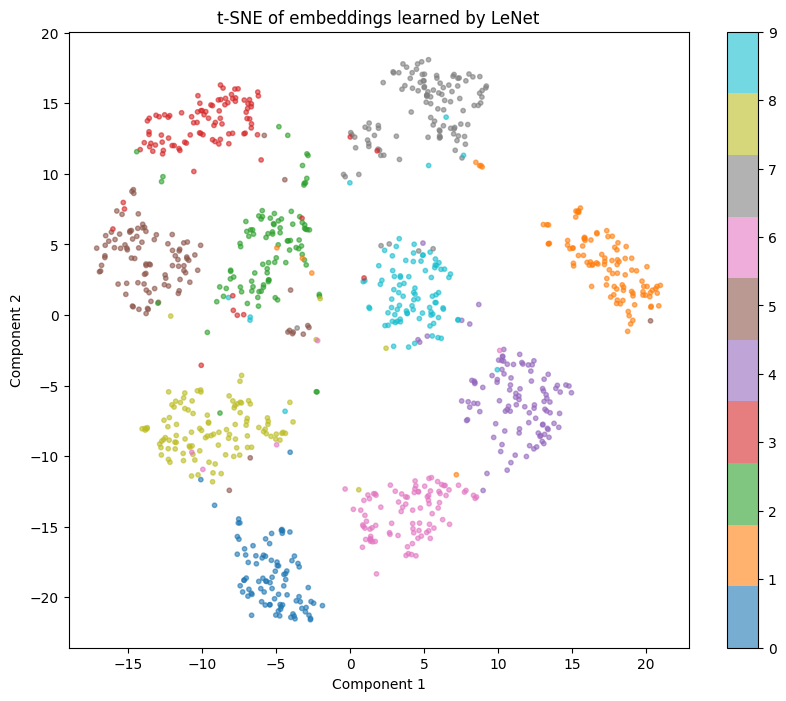

In [12]:
model.eval()

max_samples = 1000
embeddings, all_labels = [], []

with torch.no_grad():
    for i, (images, labels) in enumerate(train_dataloader):
        if len(all_labels) * train_dataloader.batch_size >= max_samples:
            break
        images = images.to(device)
        outputs = model(images)
        embeddings.append(outputs.cpu())
        all_labels.append(labels)

embeddings = torch.cat(embeddings).numpy()
all_labels = torch.cat(all_labels).numpy()

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    max_iter=300,
    learning_rate=200,
    n_jobs=-1
)
X_embedded = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_embedded[:, 0],
    X_embedded[:, 1],
    c=all_labels,
    cmap="tab10",
    alpha=0.6,
    s=10
)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of embeddings learned by LeNet")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

When the model has learned a good data representation, points corresponding to different
classes tend to cluster relatively separately in 2D space. This visualization provides
an intuitive perspective on how the model internally organizes information and
distinguishes handwritten digit classes. Clear separation indicates that the
network-induced feature space facilitates linear classification in the final layer,
confirming that learned representations are discriminative and semantically meaningful.